<a href="https://colab.research.google.com/github/smartgrids-aau/GreenCodesPython/blob/main/Exemple_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

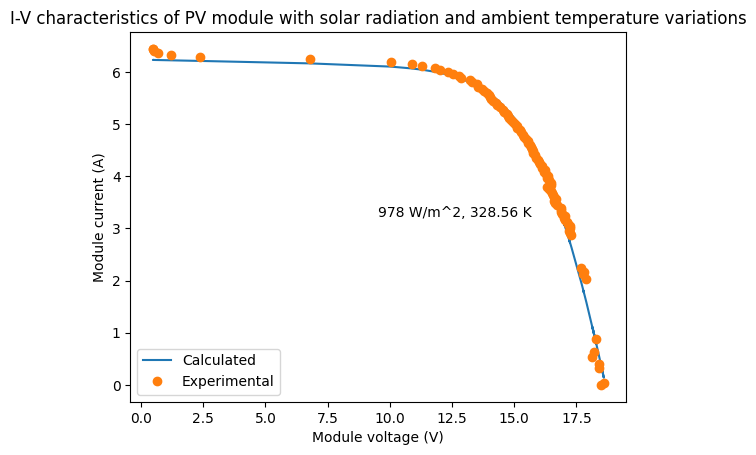

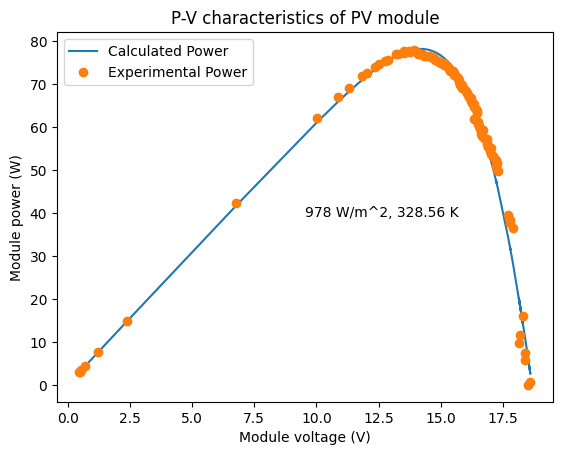

RMSE: 0.1481099256756326
MBE: 0.02193655008364142
RR: 0.990640387176342


In [4]:
#Example 2.5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
import os
from openpyxl import Workbook
from openpyxl import load_workbook


def main():
    t = time.time()
    radiation = [978]  # Array of solar radiation in (W/m^2)
    cell_temperature = [328.56]  # Array of ambient temperature in (K)
    sheet = 7

    # Reading the experimental voltage and current data
    df = pd.read_excel('PV Modeling Book Data Source.xls', sheet_name='Source 4')

    Ve = df.iloc[2:104, 6].values  # Experimental voltage (G3:G104)
    Ie = df.iloc[2:104, 7].values  # Experimental current (H3:H104)
    Vp = Ve.copy()

    # Ensure arrays are NumPy arrays
    Ve = np.array(Ve, dtype=float)
    Ie = np.array(Ie, dtype=float)
    Vp = np.array(Vp, dtype=float)

    # Save to desktop
    with open('var_fitness_function.pkl', 'wb') as f:
        pickle.dump({'Vp': Vp, 'Ie': Ie}, f)

    solar_radiation = np.array(radiation, dtype=float) / 1000
    G = solar_radiation
    Tc = np.array(cell_temperature, dtype=float)

    f_bestt, a_bestt, Rs_bestt, Rp_bestt, Iph_bestt, Io_bestt = PV_MODELING_BASED_DE_ALGORITHM(G, Tc)

    a_best = a_bestt
    Rs_best = Rs_bestt
    Rp_best = Rp_bestt
    Iph_best = Iph_bestt
    Io_best = Io_bestt
    f_best = f_bestt

    # Computing I-V characteristics
    Nsc = 36
    k = 1.3806503e-23
    q = 1.60217646e-19
    VT = (Nsc * k * Tc[0]) / q

    Ip = np.zeros_like(Vp, dtype=float)
    for h in range(5):
        # Ensure all variables are properly typed
        exp_term = np.exp((Vp + Ip * Rs_best) / (a_best * VT))
        numerator = Iph_best - Ip - Io_best * (exp_term - 1) - ((Vp + Ip * Rs_best) / Rp_best)
        denominator = -1 - Io_best * (Rs_best / (a_best * VT)) * exp_term - (Rs_best / Rp_best)
        Ip = Ip - (numerator / denominator)

    # Plotting I-V Characteristics
    plt.figure()
    plt.plot(Vp, Ip, label='Calculated')
    plt.plot(Ve, Ie, 'o', label='Experimental')
    plt.title('I-V characteristics of PV module with solar radiation and ambient temperature variations')
    plt.xlabel('Module voltage (V)')
    plt.ylabel('Module current (A)')
    plt.legend()
    plt.text(0.5, 0.5, '978 W/m^2, 328.56 K', transform=plt.gca().transAxes)
    plt.show()

    # Computing PV Module Power
    Pp = Vp * Ip
    Pe = Vp * Ie

    # Plotting P-V Characteristics
    plt.figure()
    plt.plot(Vp, Pp, label='Calculated Power')
    plt.plot(Vp, Pe, 'o', label='Experimental Power')
    plt.title('P-V characteristics of PV module')
    plt.xlabel('Module voltage (V)')
    plt.ylabel('Module power (W)')
    plt.legend()
    plt.text(0.5, 0.5, '978 W/m^2, 328.56 K', transform=plt.gca().transAxes)
    plt.show()

    # Computing Error
    Iee = np.mean(Ie)
    RMSE = np.sqrt((1/len(Vp)) * np.sum((Ip - Ie)**2))
    MBE = (1/len(Vp)) * np.sum((Ip - Ie)**2)
    RR = 1 - ((np.sum((Ie - Ip)**2)) / (np.sum((Ie - Iee)**2)))

    print(f"RMSE: {RMSE}")
    print(f"MBE: {MBE}")
    print(f"RR: {RR}")

def PV_MODELING_BASED_DE_ALGORITHM(G, Tc):
    EP = 0.054
    D = 5
    Np = 10 * D
    F = 0.85
    CR = 0.6
    GEN_max = 500
    sheet = 7
    file_name = 'Results_of_Radiation_7_temperature_7.pkl'

    # Save parameters
    params = {'Np': Np, 'GEN_max': GEN_max, 'F': F, 'CR': CR}
    with open(file_name, 'wb') as f:
        pickle.dump(params, f)

    # Write to Excel
    excel_file = 'PVM4_Try_3.xlsx'
    if not os.path.exists(excel_file):
        wb = Workbook()
        wb.save(excel_file)

    # Write parameters to Excel
    write_to_excel(excel_file, sheet, 'P5', Np)
    write_to_excel(excel_file, sheet, 'Q5', GEN_max)
    write_to_excel(excel_file, sheet, 'R5', F)
    write_to_excel(excel_file, sheet, 'S5', CR)
    write_to_excel(excel_file, sheet, 'U5', EP)

    Rs_l = 0.1;  Rs_h = 2
    Rp_l = 100;  Rp_h = 5000
    a_l = 1;     a_h = 2
    Iph_l = 1;   Iph_h = 8
    Io_l = 1e-12; Io_h = 1e-5

    L = np.array([a_l, Rs_l, Rp_l, Iph_l, Io_l], dtype=float)
    H = np.array([a_h, Rs_h, Rp_h, Iph_h, Io_h], dtype=float)

    rr = 1
    a_average = np.zeros(rr, dtype=float)
    Rs_average = np.zeros(rr, dtype=float)
    Rp_average = np.zeros(rr, dtype=float)
    Iph_average = np.zeros(rr, dtype=float)
    Io_average = np.zeros(rr, dtype=float)
    f_average = np.zeros(rr, dtype=float)

    for b in range(rr):
        x = np.zeros(D, dtype=float)
        pop = np.zeros((D, Np), dtype=float)
        Fit = np.zeros(Np, dtype=float)
        r = np.zeros(3, dtype=int)

        # Initialize population
        for j in range(Np):
            for i in range(D):
                pop[i, j] = L[i] + (H[i] - L[i]) * np.random.rand()

            a = float(pop[0, j])
            Rs = float(pop[1, j])
            Rp = float(pop[2, j])
            Iph = float(pop[3, j])
            Io = float(pop[4, j])
            f = fitness_function(a, Rs, Rp, Iph, Io, G, Tc)
            Fit[j] = f

        Aa = np.zeros(GEN_max, dtype=float)
        ARs = np.zeros(GEN_max, dtype=float)
        ARp = np.zeros(GEN_max, dtype=float)
        AIph = np.zeros(GEN_max, dtype=float)
        AIo = np.zeros(GEN_max, dtype=float)
        Af = np.zeros(GEN_max, dtype=float)

        for g in range(GEN_max):
            for j in range(Np):
                # Select three random indices different from j
                r[0] = int(np.floor(np.random.rand() * Np))
                while r[0] == j:
                    r[0] = int(np.floor(np.random.rand() * Np))

                r[1] = int(np.floor(np.random.rand() * Np))
                while r[1] == j or r[1] == r[0]:
                    r[1] = int(np.floor(np.random.rand() * Np))

                r[2] = int(np.floor(np.random.rand() * Np))
                while r[2] == j or r[2] == r[0] or r[2] == r[1]:
                    r[2] = int(np.floor(np.random.rand() * Np))

                # Mutation
                w = pop[:, r[2]] + F * (pop[:, r[0]] - pop[:, r[1]])

                # Crossover
                Rnd = int(np.floor(np.random.rand() * D))
                for i in range(D):
                    if np.random.rand() < CR or Rnd == i:
                        x[i] = w[i]
                    else:
                        x[i] = pop[i, j]

                # Boundary constraint
                for i in range(D):
                    if x[i] < L[i] or x[i] > H[i]:
                        x[i] = L[i] + (H[i] - L[i]) * np.random.rand()

                # Selection
                a = float(x[0])
                Rs = float(x[1])
                Rp = float(x[2])
                Iph = float(x[3])
                Io = float(x[4])
                f = fitness_function(a, Rs, Rp, Iph, Io, G, Tc)

                if f <= Fit[j]:
                    pop[:, j] = x.copy()
                    Fit[j] = f

            # Store best solution of current generation
            n = np.min(np.abs(Fit))
            iBest = np.argmin(np.abs(Fit))
            Aa[g] = pop[0, iBest]
            ARs[g] = pop[1, iBest]
            ARp[g] = pop[2, iBest]
            AIph[g] = pop[3, iBest]
            AIo[g] = pop[4, iBest]
            Af[g] = Fit[iBest]

            if Fit[iBest] <= EP:
                FEV = g
                break

        # Find best solution across all generations
        nn = np.min(np.abs(Af))
        Ibest = np.argmin(np.abs(Af))
        a_average[b] = Aa[Ibest]
        Rs_average[b] = ARs[Ibest]
        Rp_average[b] = ARp[Ibest]
        Iph_average[b] = AIph[Ibest]
        Io_average[b] = AIo[Ibest]
        f_average[b] = Af[Ibest]

        # Write AF to Excel
        AF = Af.reshape(-1, 1)
        write_array_to_excel(excel_file, sheet, 'Z5', AF)

    # Calculate averages
    f_bestt = np.sum(f_average) / rr
    a_bestt = np.sum(a_average) / rr
    Rs_bestt = np.sum(Rs_average) / rr
    Rp_bestt = np.sum(Rp_average) / rr
    Iph_bestt = np.sum(Iph_average) / rr
    Io_bestt = np.sum(Io_average) / rr

    # Save results
    results = {'f_average': f_average}
    with open(file_name, 'wb') as f:
        pickle.dump(results, f)

    # Write f_average to Excel
    write_array_to_excel(excel_file, sheet, 'A108', f_average.reshape(1, -1))

    return f_bestt, a_bestt, Rs_bestt, Rp_bestt, Iph_bestt, Io_bestt

def fitness_function(a, Rs, Rp, Iph, Io, G, Tc):
    Nsc = 36
    k = 1.3806503e-23
    q = 1.60217646e-19
    VT = (Nsc * k * Tc[0]) / q

    # Load variables
    with open('var_fitness_function.pkl', 'rb') as f:
        data = pickle.load(f)
        Vp = np.array(data['Vp'], dtype=float)
        Ie = np.array(data['Ie'], dtype=float)

    Ip = np.zeros_like(Vp, dtype=float)

    # Ensure all parameters are float
    a = float(a)
    Rs = float(Rs)
    Rp = float(Rp)
    Iph = float(Iph)
    Io = float(Io)
    VT = float(VT)

    for h in range(5):
        # Break down the calculation to avoid type issues
        exp_arg = (Vp + Ip * Rs) / (a * VT)
        exp_term = np.exp(exp_arg)

        numerator = Iph - Ip - Io * (exp_term - 1) - ((Vp + Ip * Rs) / Rp)
        denominator = -1 - Io * (Rs / (a * VT)) * exp_term - (Rs / Rp)

        Ip = Ip - (numerator / denominator)

    N = len(Vp)
    f = np.sqrt((1/N) * np.sum((Ie - Ip)**2))

    return float(f)

def write_to_excel(file_path, sheet_num, cell, value):
    """Helper function to write a single value to Excel"""
    try:
        # Convert cell reference (e.g., 'P5') to row, col indices
        col = ord(cell[0]) - ord('A')
        row = int(cell[1:]) - 1

        # Read existing file or create new one
        try:
            df = pd.read_excel(file_path, sheet_name=f'Sheet{sheet_num}', header=None)
        except:
            df = pd.DataFrame()

        # Ensure DataFrame is large enough
        max_row = max(row + 1, len(df))
        max_col = max(col + 1, len(df.columns) if len(df.columns) > 0 else 0)

        if df.empty or df.shape[0] < max_row or df.shape[1] < max_col:
            new_df = pd.DataFrame(index=range(max_row), columns=range(max_col))
            if not df.empty:
                new_df.iloc[:df.shape[0], :df.shape[1]] = df.values
            df = new_df

        # Set the value
        df.iloc[row, col] = value

        # Write back to Excel
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
            df.to_excel(writer, sheet_name=f'Sheet{sheet_num}', index=False, header=False)
    except Exception as e:
        print(f"Error writing to Excel: {e}")

def write_array_to_excel(file_path, sheet_num, start_cell, array):
    """Helper function to write an array to Excel"""
    try:
        # Convert cell reference to row, col indices
        col = ord(start_cell[0]) - ord('A')
        row = int(start_cell[1:]) - 1

        # Read existing file or create new one
        try:
            df = pd.read_excel(file_path, sheet_name=f'Sheet{sheet_num}', header=None)
        except:
            df = pd.DataFrame()

        # Ensure DataFrame is large enough
        if array.ndim == 1:
            array = array.reshape(-1, 1)

        max_row = max(row + array.shape[0], len(df) if not df.empty else 0)
        max_col = max(col + array.shape[1], len(df.columns) if not df.empty and len(df.columns) > 0 else 0)

        if df.empty or df.shape[0] < max_row or df.shape[1] < max_col:
            new_df = pd.DataFrame(index=range(max_row), columns=range(max_col))
            if not df.empty:
                new_df.iloc[:df.shape[0], :df.shape[1]] = df.values
            df = new_df

        # Set the array values
        df.iloc[row:row+array.shape[0], col:col+array.shape[1]] = array

        # Write back to Excel
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
            df.to_excel(writer, sheet_name=f'Sheet{sheet_num}', index=False, header=False)
    except Exception as e:
        print(f"Error writing array to Excel: {e}")

if __name__ == "__main__":
    main()
